In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

# pastas de saída
OUT = Path('outputs/resultados/semana5')
OUT.mkdir(parents=True, exist_ok=True)

# funções métricas (robustas)
def mae(y_true, y_pred):
    y_true, y_pred = pd.Series(y_true), pd.Series(y_pred)
    dfm = pd.concat([y_true, y_pred], axis=1).dropna()
    return (dfm.iloc[:,0] - dfm.iloc[:,1]).abs().mean()

def rmse(y_true, y_pred):
    y_true, y_pred = pd.Series(y_true), pd.Series(y_pred)
    dfm = pd.concat([y_true, y_pred], axis=1).dropna()
    return np.sqrt(((dfm.iloc[:,0] - dfm.iloc[:,1])**2).mean())

def mape(y_true, y_pred):
    y_true, y_pred = pd.Series(y_true), pd.Series(y_pred)
    dfm = pd.concat([y_true, y_pred], axis=1).dropna()
    dfm = dfm[dfm.iloc[:,0] != 0]
    return (dfm.iloc[:,0].sub(dfm.iloc[:,1]).abs().div(dfm.iloc[:,0]).mean()) * 100

print('Setup OK — outputs em:', OUT)


Setup OK — outputs em: outputs\resultados\semana5


In [2]:
csv_path = Path('btc_clean.csv')

if csv_path.exists():
    df = pd.read_csv(csv_path, parse_dates=['Date'], index_col='Date')
    print('Carregado de', csv_path)
else:
    import yfinance as yf
    df = yf.download('BTC-USD', start='2016-01-01', end=None)
    print('Baixado via yfinance')

# achatar MultiIndex de colunas se houver
if isinstance(df.columns, pd.MultiIndex):
    df.columns = ['_'.join([str(x) for x in col if str(x) and str(x) != '']).strip() for col in df.columns]

df.columns = [c.strip() for c in df.columns]
print('Colunas detectadas:', df.columns.tolist())

# identificar coluna close
close_candidates = [c for c in df.columns if 'close' in c.lower()]
if not close_candidates:
    raise ValueError('Nenhuma coluna com "close" encontrada. Verifique df.columns acima.')
close_col = close_candidates[0]
print('Usando coluna:', close_col)

# série limpa
series = pd.to_numeric(df[close_col], errors='coerce').dropna()
series.index = pd.to_datetime(series.index)
series = series.sort_index()
series = series.asfreq('D')     # garante frequência diária
series = series.ffill()         # preenche pequenas lacunas
print('Série pronta:', series.index.min(), '->', series.index.max(), '| pontos =', len(series))
series.tail()


[*********************100%***********************]  1 of 1 completed

Baixado via yfinance
Colunas detectadas: ['Close_BTC-USD', 'High_BTC-USD', 'Low_BTC-USD', 'Open_BTC-USD', 'Volume_BTC-USD']
Usando coluna: Close_BTC-USD
Série pronta: 2016-01-01 00:00:00 -> 2025-09-16 00:00:00 | pontos = 3547


Date
2025-09-12    116101.578125
2025-09-13    115950.507812
2025-09-14    115407.656250
2025-09-15    115407.656250
2025-09-16    115187.156250
Freq: D, Name: Close_BTC-USD, dtype: float64

In [3]:
split = int(len(series) * 0.8)
train = series.iloc[:split].copy()
test  = series.iloc[split:].copy()
print('Treino:', train.index.min(), '->', train.index.max(), '| n =', len(train))
print('Teste :', test.index.min(),  '->', test.index.max(),  '| n =', len(test))


Treino: 2016-01-01 00:00:00 -> 2023-10-07 00:00:00 | n = 2837
Teste : 2023-10-08 00:00:00 -> 2025-09-16 00:00:00 | n = 710


In [4]:
pred_naive = series.shift(1).loc[test.index]
df_preds = pd.DataFrame({'Real': test, 'Naive': pred_naive})
df_preds.to_csv(OUT / 'predictions_baseline_naive.csv')
print('Naive salvo em', OUT / 'predictions_baseline_naive.csv')
display(df_preds.head())


Naive salvo em outputs\resultados\semana5\predictions_baseline_naive.csv


,Real,Naive
Date,,
2023-10-08,27935.089844,27968.839844
2023-10-09,27583.677734,27935.089844
2023-10-10,27391.019531,27583.677734
2023-10-11,26873.320312,27391.019531
2023-10-12,26756.798828,26873.320312


In [5]:
# criar features com os mesmos índices da série
df_feat = pd.DataFrame({'Close': series})
df_feat['lag1'] = df_feat['Close'].shift(1)
df_feat['lag7'] = df_feat['Close'].shift(7)
df_feat = df_feat.dropna()

# dividir por datas (manter cronologia)
train_feat = df_feat[df_feat.index <= train.index.max()].copy()
test_feat  = df_feat[df_feat.index >  train.index.max()].copy()

X_train = train_feat[['lag1','lag7']].values
y_train = train_feat['Close'].values
X_test  = test_feat[['lag1','lag7']].values
y_test  = test_feat['Close'].values

lr = LinearRegression()
lr.fit(X_train, y_train)
pred_lr = lr.predict(X_test)

# série com previsões e reindex para o índice do teste principal
pred_lr_series = pd.Series(pred_lr, index=test_feat.index)
pred_lr_aligned = pred_lr_series.reindex(test.index)   # pode criar NaNs onde índices não coincidem
df_preds['LinearRegression'] = pred_lr_aligned
df_preds.to_csv(OUT / 'predictions_naive_lr.csv')
print('Previsões LR salvas em', OUT / 'predictions_naive_lr.csv')
display(df_preds.tail())


Previsões LR salvas em outputs\resultados\semana5\predictions_naive_lr.csv


,Real,Naive,LinearRegression
Date,,,
2025-09-12,116101.578125,115507.539062,115422.860659
2025-09-13,115950.507812,116101.578125,116028.206770
2025-09-14,115407.656250,115950.507812,115864.269287
2025-09-15,115407.656250,115407.656250,115304.927763
2025-09-16,115187.156250,115407.656250,115311.403790


In [6]:
models = ['Naive','LinearRegression']
rows = []
for m in models:
    rows.append({
        'model': m,
        'MAE': mae(df_preds['Real'], df_preds[m]),
        'RMSE': rmse(df_preds['Real'], df_preds[m]),
        'MAPE(%)': mape(df_preds['Real'], df_preds[m])
    })

metrics_df = pd.DataFrame(rows).set_index('model').round(6)
metrics_df.to_csv(OUT / 'metrics_naive_lr.csv')
print('Métricas salvas em', OUT / 'metrics_naive_lr.csv')
display(metrics_df)

# salvar resumo textual rápido
with open(OUT / 'metrics_summary.txt','w',encoding='utf-8') as fh:
    fh.write('Métricas (Naive vs LinearRegression)\n\n')
    for idx, r in metrics_df.iterrows():
        fh.write(f'{idx}: MAE={r["MAE"]:.4f} | RMSE={r["RMSE"]:.4f} | MAPE={r["MAPE(%)"]:.2f}%\n')
print('Resumo textual salvo em', OUT / 'metrics_summary.txt')


Métricas salvas em outputs\resultados\semana5\metrics_naive_lr.csv


,MAE,RMSE,MAPE(%)
model,,,
Naive,1314.285508,1874.572705,1.795778
LinearRegression,1322.008682,1883.693071,1.805102


Resumo textual salvo em outputs\resultados\semana5\metrics_summary.txt


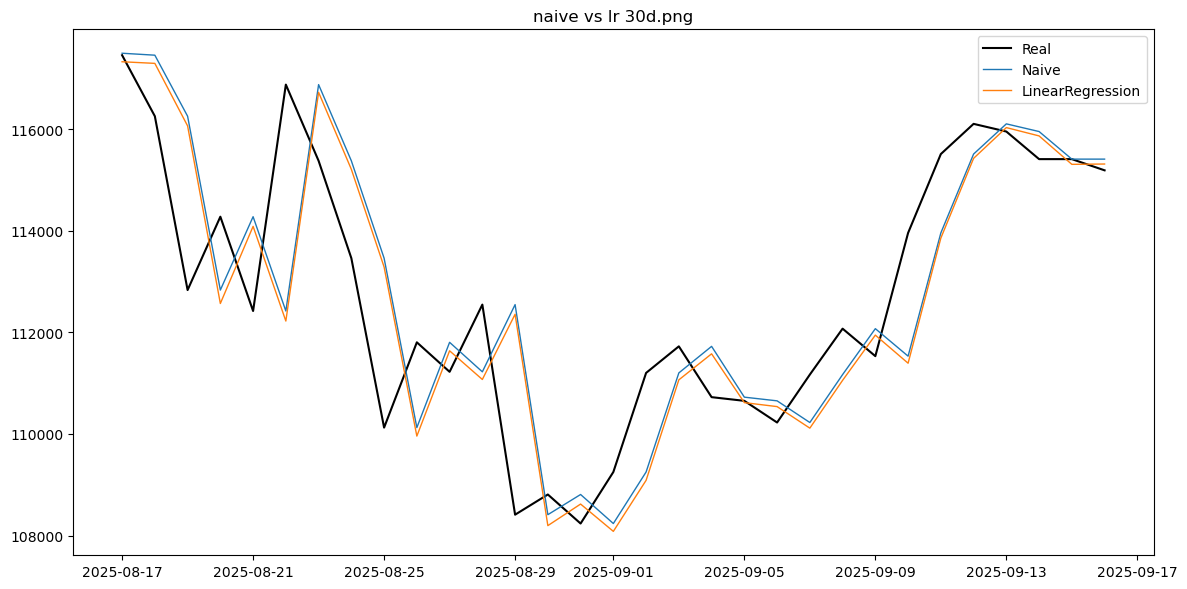

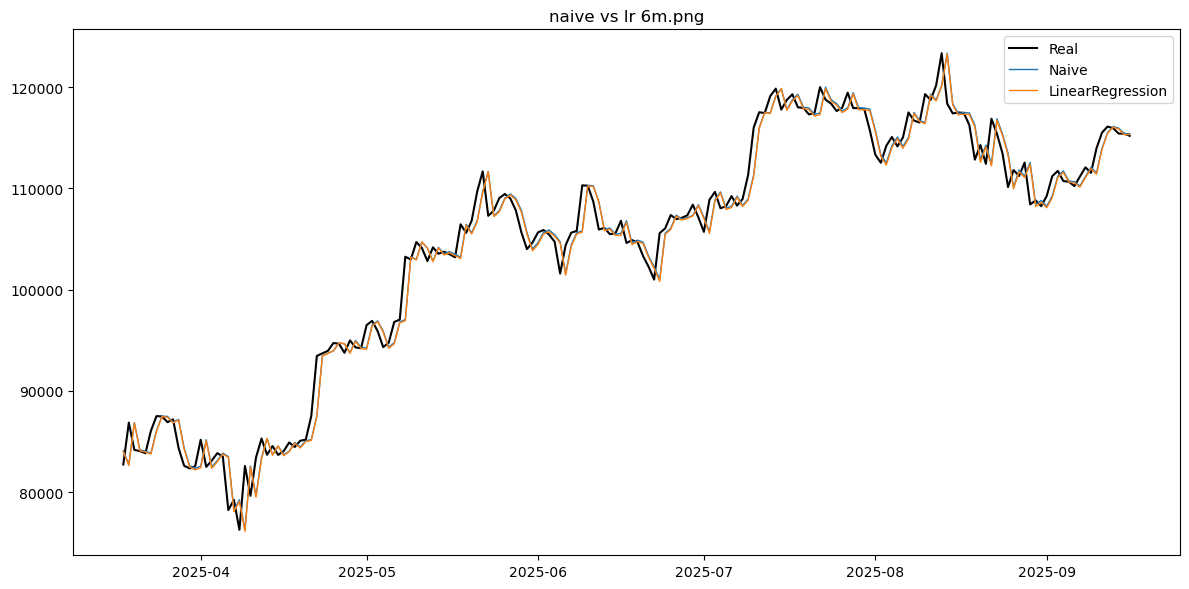

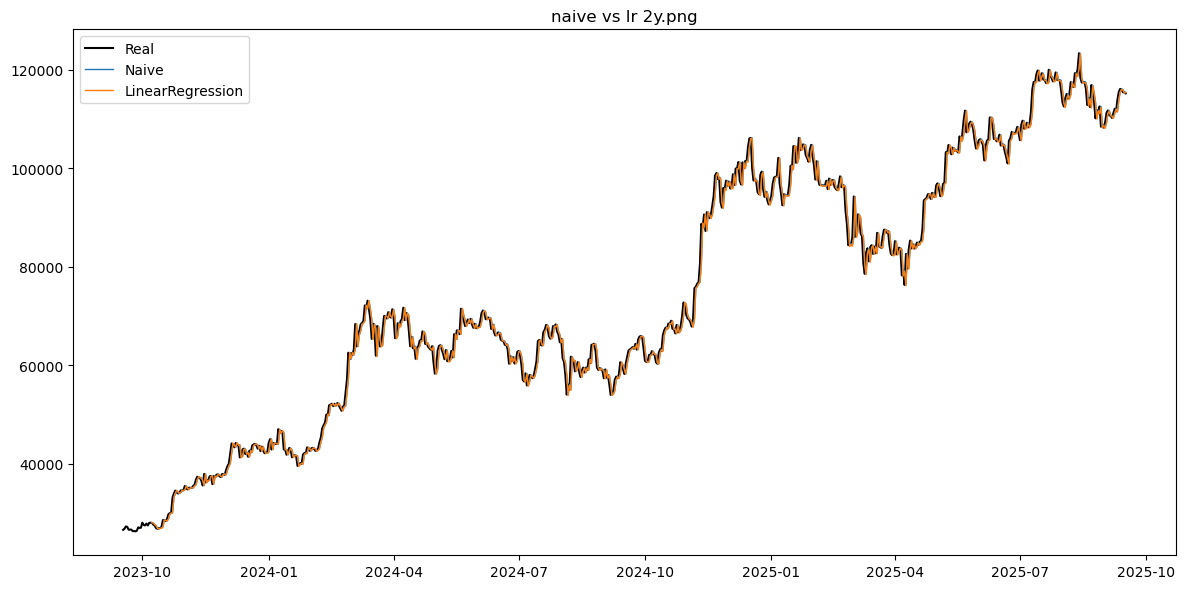

Gráficos salvos em outputs\resultados\semana5


In [7]:
def plot_period(series, preds_df, fname, dias):
    end = series.index.max()
    start = end - pd.Timedelta(days=dias)
    plt.figure(figsize=(12,6))
    plt.plot(series[start:].index, series[start:].values, label='Real', linewidth=1.5, color='black')
    for col in preds_df.columns:
        p = preds_df[col].reindex(series[start:].index)
        if p.isna().all():
            continue
        plt.plot(p.index, p.values, label=col, linewidth=1)
    plt.title(fname.replace('_',' '))
    plt.legend()
    plt.tight_layout()
    plt.savefig(OUT / fname, dpi=150)
    plt.show()

# definir quais colunas existem (evita KeyError)
cols_exist = [c for c in ['Naive','LinearRegression'] if c in df_preds.columns]

# 30 dias
plot_period(series, df_preds[cols_exist], 'naive_vs_lr_30d.png', dias=30)
# 6 meses
plot_period(series, df_preds[cols_exist], 'naive_vs_lr_6m.png', dias=182)
# 2 anos
plot_period(series, df_preds[cols_exist], 'naive_vs_lr_2y.png', dias=730)

print('Gráficos salvos em', OUT)


In [8]:
# salvar previsões completas
df_preds.to_csv(OUT / 'predictions_all_final.csv')
# salvar métricas já foi feito (metrics_naive_lr.csv)

# resumo pronto para colar no Notion
notion_text = f'''
Resumo - Encerramento da semana (12/09)

Modelos mantidos: Naive (baseline) e Regressão Linear (lags 1 e 7).
Modelos excluídos do plano atual: ARIMA e SNaive7 (decisão justificada por problemas de convergência/desempenho).

Métricas (Naive vs LinearRegression):
{metrics_df.to_string()}

Arquivos gerados:
- {OUT / 'predictions_all_final.csv'}
- {OUT / 'metrics_naive_lr.csv'}
- {OUT / 'metrics_summary.txt'}
- Gráficos: naive_vs_lr_30d.png, naive_vs_lr_6m.png, naive_vs_lr_2y.png

Observação: Naive continua muito competitivo (MAPE ~1.8% conforme seus dados). Regressão Linear está muito próxima — manter ambos como referência no produto.
'''

with open(OUT / 'notion_summary.txt','w',encoding='utf-8') as fh:
    fh.write(notion_text)

print('Resumo para Notion salvo em', OUT / 'notion_summary.txt')
print('\nCole este texto na página da semana no Notion e anexe os PNGs e CSVs.')


Resumo para Notion salvo em outputs\resultados\semana5\notion_summary.txt

Cole este texto na página da semana no Notion e anexe os PNGs e CSVs.
